In [ ]:
!pip install torch_geometric

In [ ]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

In [84]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCNModel(torch.nn.Module):
    def __init__(self, num_node_features, latent : int, latent_layers : int):
        super().__init__()

        self.head = torch.nn.ModuleList()
        self.rep = torch.nn.ModuleList()
        self.num_node_features = num_node_features

        self.latent = latent # The latent repeating dimension
        self.latent_layers = latent_layers # The number of repeating layers.

        # Adding layers to the head network (contracting dimension layers)
        x = num_node_features
        while x > latent :
          self.head.append(GCNConv(x, x//2))
          x = x//2

        # Case of head and rep I/O not matching in dimensions.
        if (x < latent):
          self.head.append(GCNConv(x,self.latent))

        # Adding the repeating latent dimension layer.
        for i in range(self.latent_layers):
          self.rep.append(GCNConv(latent, latent))

        # Final classification layer.
        self.convfinal = GCNConv(latent, dataset.num_classes)

        # Reset parameter for initialization.
        self.reset_parameters()

    def reset_parameters(self):

        for i in self.head:
          i.reset_parameters()
        for i in self.rep:
          i.reset_parameters()
        self.convfinal.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Head network.
        for i in range(len(self.head)):
          x = self.head[i](x, edge_index)
          x = F.relu(x)
          x = F.dropout(x, training=self.training)

        # Repeat network.
        for i in range(self.latent_layers):
          x = self.rep[i](x, edge_index)
          x = F.relu(x)
          x = F.dropout(x, training=self.training)

        # Final classification layer.
        x = self.convfinal(x, edge_index)

        return F.log_softmax(x, dim=1)

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCNModel(dataset.num_node_features, 22, 1).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(150):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [77]:
model.eval()
pred = model(data).argmax(dim=1)
print(pred)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

tensor([3, 4, 4,  ..., 2, 3, 3])
Accuracy: 0.7050


tensor([3, 4, 4,  ..., 1, 3, 3])
Accuracy: 0.7490
tensor([3, 4, 4,  ..., 5, 4, 4])
Accuracy: 0.5700
tensor([0, 0, 0,  ..., 0, 0, 0])
Accuracy: 0.1360
tensor([6, 6, 1,  ..., 6, 6, 2])
Accuracy: 0.1340
tensor([6, 6, 0,  ..., 6, 6, 5])
Accuracy: 0.1320


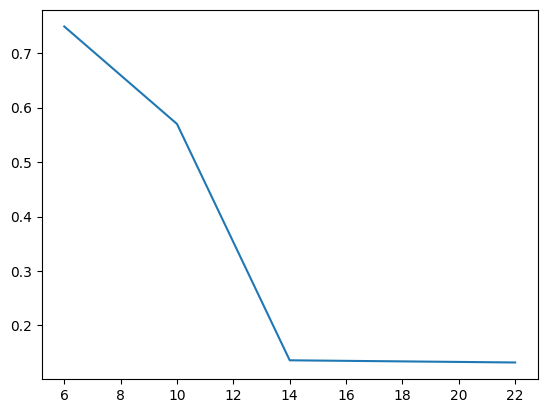

In [86]:
import matplotlib.pyplot as plt
accu = []
step = [i for i in range(6, 23, 4)]
for i in range(0,20,4):

  # Initialize model and optimizer.
  model = GCNModel(dataset.num_node_features, 22, i).to(device)
  data = dataset[0].to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

  # Train model.
  model.train()
  for epoch in range(150):
      optimizer.zero_grad()
      out = model(data)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()

  # Evaluate model.
  model.eval()
  pred = model(data).argmax(dim=1)
  print(pred)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
  acc = int(correct) / int(data.test_mask.sum())
  accu.append(acc)
  print(f'Accuracy: {acc:.4f}')


plt.plot(step, accu)
plt.show()



In [85]:
class SkipGCNModel(torch.nn.Module):
    def __init__(self, num_node_features, latent : int, latent_layers : int):
        super().__init__()

        self.head = torch.nn.ModuleList()
        self.rep = torch.nn.ModuleList()
        self.num_node_features = num_node_features

        self.latent = latent # The latent repeating dimension
        self.latent_layers = latent_layers # The number of repeating layers.

        # Adding layers to the head network (contracting dimension layers)
        x = num_node_features
        while x > latent :
          self.head.append(GCNConv(x, x//2))
          x = x//2

        # Case of head and rep I/O not matching in dimensions.
        if (x < latent):
          self.head.append(GCNConv(x,self.latent))

        # Adding the repeating latent dimension layer.
        for i in range(self.latent_layers):
          self.rep.append(GCNConv(latent, latent))

        # Final classification layer.
        self.convfinal = GCNConv(2 * latent, dataset.num_classes)

        # Reset parameter for initialization.
        self.reset_parameters()

    def reset_parameters(self):
        for i in self.head:
          i.reset_parameters()
        for i in self.rep:
          i.reset_parameters()
        self.convfinal.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Head network.
        for i in range(len(self.head)):
          x = self.head[i](x, edge_index)
          x = F.relu(x)
          x = F.dropout(x, training=self.training)

        y = x # Concat features.

        # Repeat network.
        for i in range(self.latent_layers):
          x = self.rep[i](x, edge_index)
          x = F.relu(x)
          x = F.dropout(x, training=self.training)

        # Final classification layer.
        x = self.convfinal(torch.cat((x, y), 1), edge_index)

        return F.log_softmax(x, dim=1)

tensor([3, 4, 4,  ..., 5, 3, 3])
Accuracy: 0.7440
tensor([3, 4, 4,  ..., 2, 3, 3])
Accuracy: 0.7660
tensor([3, 4, 4,  ..., 0, 3, 3])
Accuracy: 0.6860
tensor([3, 4, 4,  ..., 5, 3, 3])
Accuracy: 0.7830
tensor([3, 4, 4,  ..., 3, 3, 3])
Accuracy: 0.7460


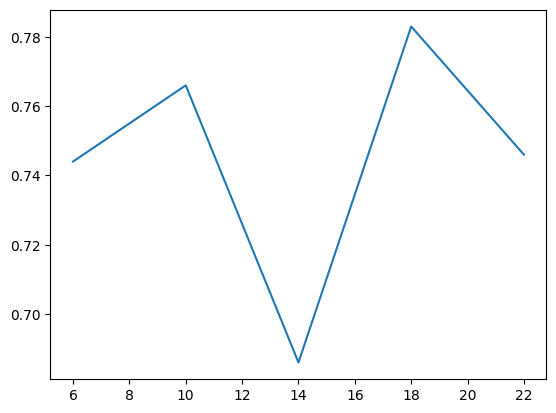

In [88]:
import matplotlib.pyplot as plt
accu = []
step = [i for i in range(6, 23, 4)]
for i in range(0,20,4):

  # Initialize model and optimizer.
  model = SkipGCNModel(dataset.num_node_features, 22, i).to(device)
  data = dataset[0].to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

  # Train model.
  model.train()
  for epoch in range(150):
      optimizer.zero_grad()
      out = model(data)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()

  # Evaluate model.
  model.eval()
  pred = model(data).argmax(dim=1)
  print(pred)
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
  acc = int(correct) / int(data.test_mask.sum())
  accu.append(acc)
  print(f'Accuracy: {acc:.4f}')


plt.plot(step, accu)
plt.show()


In [91]:
step

[6, 10, 14, 18, 22]

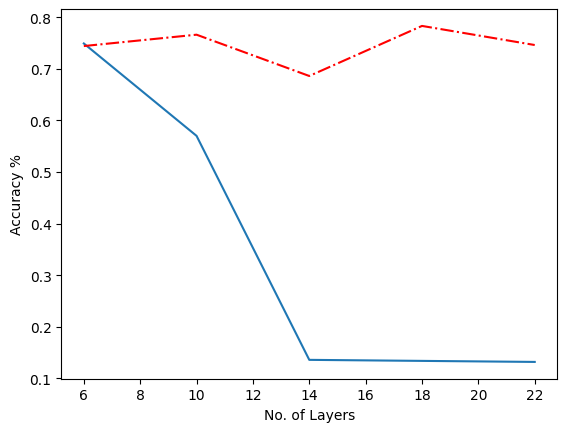

In [94]:
# Final comparision between the accuracies of the two methods.

GCN = [0.7490, 0.5700, 0.1360, 0.1340, 0.1320]
SkipGCN = [0.744, 0.766, 0.686, 0.783, 0.746]
step = [6, 10, 14, 18, 22]
plt.plot(step, GCN, label='Normal GCN Model')
plt.plot(step, SkipGCN, "-.", color='red', label='Skip connection')
plt.xlabel("No. of Layers")
plt.ylabel("Accuracy %")
plt.show()

# Inference
The graph indicates that increasing the no. of layers in a normal GCN Network leads to reduced performance and one of the possible ways to fix this is adding a skip connection between the lower and the upper layers.

There reduced performance can be possible due to two reasons:

1.) The problem of vanishing gradients observed in larger normal neural networks.

2.) The oversmoothing effects of GNNs/GCNs at deeper layers.

Skip connection can solve both by providing a seperate path for the gradient to flow and also provide the reperesenttaion from higher layers which have not coverged to a single common representation for all nodes.